In [2]:
%load_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm.notebook import tqdm

from src.cache import cache

set_matplotlib_formats("svg")

<Axes: >

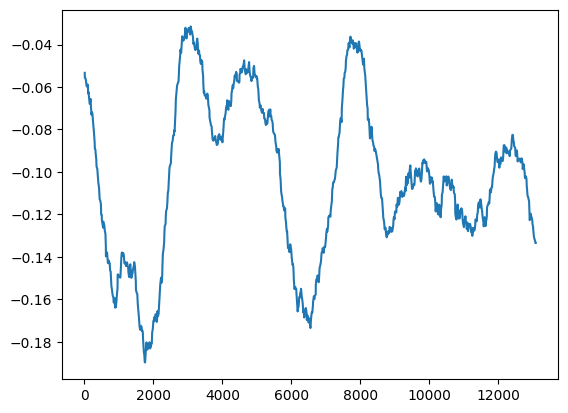

In [ ]:
from src.models.time_series import get_lagged_df

df = get_lagged_df(
    "media_combined_protest",
    instruments="pc_weather_season",
    lags=range(-7, 1),
    step=1,
    cumulative=True,
    ignore_group=True,
    ignore_medium=True,
    region_dummies=True,
)
list(df.columns)
df.query("region_Berlin_lag0 == 1")["pc_seasonal_7"].plot()

In [ ]:
from src.models.instrumental_variable import get_rf_params

rf1, rf2 = get_rf_params()
print(rf1, rf2)
print(rf1 == rf2)

{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200} {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
True


In [ ]:
from src.models.instrumental_variable import check_for_improvement

results = check_for_improvement("weather_")
for clf, (a, b, p) in results.items():
    print(
        f"{clf}: {a.mean():.3f} ± {a.std():.3f} vs {b.mean():.3f} ± {b.std():.3f} -- t-test p={p:.3f}"
    )

LogisticRegression: 0.201 ± 0.057 vs 0.195 ± 0.057 -- t-test p=0.880
RandomForestClassifier: 0.219 ± 0.073 vs 0.213 ± 0.081 -- t-test p=0.761


In [ ]:
results = check_for_improvement("covid_")
for clf, (a, b, p) in results.items():
    print(
        f"{clf}: {a.mean():.3f} ± {a.std():.3f} vs {b.mean():.3f} ± {b.std():.3f} -- t-test p={p:.3f}"
    )

LogisticRegression: 0.201 ± 0.057 vs 0.196 ± 0.058 -- t-test p=0.770
RandomForestClassifier: 0.221 ± 0.073 vs 0.189 ± 0.114 -- t-test p=0.973


Sargan-Hansen test:

H0: The instruments are valid, that is they are uncorrelated with the error term of the structural equation.
See: InstrumentalVariablesEstimation2023, sheppardBashtageLinearmodelsRelease2023